In [1]:
import os
import numpy as np
from sklearn.datasets import make_moons, load_iris, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#To make the notebook's output stabel across runs
np.random.seed(42)

#Uses Jupyter's own backend to plot
%matplotlib inline

#To make pretty figures
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

#Path to saving images
IMAGE_PATH = os.path.join("images")
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension ,dpi=resolution)

***Ensemble Learning*** is a technique where you take a group of predictors (such as classifiers and regressors) and you aggregate their predictions, which is most often better than an individual predictor.

A group of predictors is called an ***ensemble***<br>
An Ensemble Learning algorithm is called an ***Ensemble method***

An example of **Ensemble method**: train a group of Decision Tree classifiers, each on a different random subset of the training set. To make the predictions, you obtain the predictions of all the individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a ***Random Forest***, as simply as it may sound, it's one of the most powerful Machine Learning algorithms available today

**When should I use an Esemble method?**

It's often used near the end of a project, once a few good predictors have been built, combine them into an even better predictor

We will cover the most popular **Ensemble methods**, _bagging_, _boosting_ and _stacking_

# Section: Voting Classifiers

***Hard voting*** is when you aggregate the predictions of several classifiers and predict the class that get the most votes (a majority vote classifier)

This voting classifier often achieves a higher accuracy than the best calssifier in the ensemble. Even if each classifier is a ***weak learner*** (it does slightly better than random guessing), the ensemble can still be a ***strong learner*** (achieving high accuracy), provided there are a sufficent number of weak learners and they're sufficiently diverse

**Ensemble methods**  work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble's accuracy

Let's create and train a voting classifier (**hard voting**), composed of three diverse classifiers

<img src="images/Ensemble and RF - Hard voting classifier predictions.png">

In [2]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
log_clf_hardv = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf_hardv = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf_hardv = SVC(gamma="scale", random_state=42)

voting_clf_hardv = VotingClassifier(
    estimators = [("lr", log_clf_hardv), ("rf", rnd_clf_hardv), 
                  ("svc", svm_clf_hardv)],
    voting = "hard"
)

In [4]:
voting_clf_hardv.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [5]:
for clf in (log_clf_hardv, rnd_clf_hardv, svm_clf_hardv, voting_clf_hardv):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


***Soft voting*** is when you predict the class with the highest class probabilty, averaged over all the individual classifiers. Assuming that all classifiers are able to estimate class probablities - they have the _predict_proba()_ method

It often achieves a higher performance than hard voting beause it gives more weight to highly confident votes

Let's create and train a voting classifier(**soft voting**), composed of three diverse classifiers

**Note** SVC doesn't have the _predict_proba()_ method by default, so we need to set _probability=True_ hyperparameter (this makes SVC use cross validation to estimate class probabilities, slowing down training), then it will add a _predict proba()_ method

In [6]:
log_clf_softv = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf_softv = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf_softv = SVC(gamma="scale", probability=True, random_state=42)

voting_clf_softv = VotingClassifier(
    estimators = [("lr", log_clf_softv), ("rf", rnd_clf_softv), 
                  ("svm", svm_clf_softv)],
    voting = "soft"
)
voting_clf_softv.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svm', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
for clf in (log_clf_softv, rnd_clf_softv, svm_clf_softv, voting_clf_softv):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


As we can see it achieved a higher accuracy, 92% (91.2% for **hard voting**)

# End Of Section: Voting Classifiers

# Section: Bagging And Pasting

We've just seen that in order to get a diverse set of classifiers, we need different algorithms. Another approach is to use the same training algorithm for every predictor (e.g classifier) and train them on different random subsets of the training set

When sampling is performed ***with replacement***, it's ***called bagging*** (short for bootstrap aggregating). When sampling is performed ***without replacement***, it's ***called pasting***

That is, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor

<img src="images/Ensemble and RF - Bagging and pasting on different random samples.png">

After all the classifiers are trained, the ensemble can make a prediction for a new instace by aggregating the predictions of all classifiers. The aggregation functions is typically **the _statistical mode_ (the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression.**

**Each individual predictor** has **a higher bias** than if it were trained on the original training set, but **aggregation reduces both bias and variance.** Generally, the net result is that the **ensemble has a similar bias but a lower variance than a single predictor**

Bagging and pasting **scale very well** - predictors can all be **trained and made in parallel**

##### Bagging and pasting in Scikit Learn

We'll create an ensemble of 500 Decision Tree classifiers: 
<ul>
    <li>Each is trained on 100 training instances randomly sampled for the training set with replacement (example of <strong>bagging</strong>, set <em>bootstrap=False</em> for <strong>pasting</strong>)</li>
    <li>The <em>n_jobs</em> indicates the number of CPU cores to use for training and predictions (-1 tells Scikit Learn to use all cores)</li>
</ul>

The _BagginClassifier_ automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (if it has _predict_proba()_), which is the case for with Decision Tree classifiers

In [8]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

In [9]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred_tree)

0.856

We'll compare the decision boundaries of a single Decision Tree with that of a bagging ensemble of 500 trees. 

The folloing plot shows that the ensemble will most likely generalize better: it has a comparable bias but a smaller variance (it has roughly the same number of errors, but the decision boundary is less irregular)

In [10]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure Ensemble and RF - Decision tree vs bagging ensemble of 500 trees


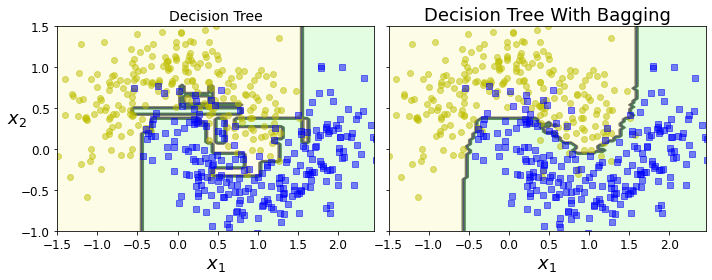

Figure 7-5


In [11]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Tree With Bagging", fontsize=18)
plt.ylabel("")

save_fig("Ensemble and RF - Decision tree vs bagging ensemble of 500 trees")
plt.show()
print("Figure 7-5")

Bootstraping introduces a bit more diversity in the subsets that each predictor is trained on, thus bagging ends up with a slightly higher bias that pasting; but the extra diversity also means that the predictors end up being less correlated, to the ensemble's variance is reduced.

Overall, bagging results in better model. However, if you have spare time and CPU power, you can use cross validation to evaluate both bagging and pasting then select the one that works best

##### Out-of-bag evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default _BaggingClassifier_ samples _m_ (size of the training set) training instances with replacement (_bootstrap=True_).

This means that **only 67% of the training instances are sampled** on average for each predictor. The remaining **37% are called _out-of-bag_(oob)**. Note that they aren't the same for all predictors

**Since a predictor never sees the oob instances during training, it can be evaluated on them, without the need for a separate validation set.** You can evaluate the ensemble itself by averaging out the oob evaluations of each predictors

Let's demonstrate oob evaluation with Scikit Learn

In [12]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

The oob evaluation indicates that it's likely to achieve about 91% accuracy on the test set. Let's verify this:

In [13]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

Since BaggingClassifier (which is the base estimator) has a _predict_proba()_ method, we can check the oob decision function of each training instance, which will return a class probability. As seen bellow, the oob estimates that the first training instance has a 67.7% probability of belonging to the positive class

In [14]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

# End Of Section: Bagging And Pasting

# Section: Random Patches And Random Subspaces

The ***BaggingClassifier supports sampling the features as well.*** Sampling is controlled by two hyperparameters: ***max_features*** and ***bootstrap_features***. So, each predictor will be trained on a random subset of the input feature.

This technique is very useful when dealing with high dimensional input: i.g, images. Sampling both from training instances and features is called the ***Random Pathces*** method. Keeping all training instances (_bootstarp=False, max_samples=1.0_) but sampling features (_bootstrap_features=True, max_feature=<0.1_) is called ***Random Subspaces*** method

Sampling features results in more predictor diversity, trading a bit more bias for lower variance

# End Of Section: Random Patches And Random Subspaces

# Section: Random Forests

**Random Forests** is an ensemble of decision trees, trained with the bagging method (sometimes with pasting), typically with _max_samples_ set to the size of the training set and optimized for decision trees.

The **Random Forest** introduces extra randomness when growing trees; **it searches for the best feature among random subset of features**, instead of searching for the very best feature when splitting a node. 

Thus, the algorithm has greater diversity, which trades a higher bias for a lower variance, generally yielding an overall better model. 

In [15]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, random_state=42)

Let's compare Random Forests predictions to bagging with a Decision Tree

In [16]:
y_pred_rf = rnd_clf.predict(X_test)

In [17]:
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.936

Random forest predicted **93.6%**, whereas Bagging with a Decision Tree predicted **91.2%**. With a 2.4% difference, they're quite similar

##### Extra trees

When growing a tree in a Random Forest, **at each node only a random subset of the features is considered for splitting.** It's possible to make trees even **more random by also using random thresholds for each feature** rather than searching for the best possible thresholds (this is what regular Decision Trees do).

A forest of such _extremely_ random trees is  called an ***Extremely Randomized Trees*** ensemble (Extra trees for short). This technique also trades more bias for a lower variance. Moreover, it also makes this type of tree much faster to train than regular Random Forests, becuase finding the best possible threshold for each feature is the most time consuming task for growing a tree

> It's very hard to know in advance whether a RandomForestClassifier will perform better or worse than an ExtraTreesClassifier. Generally, the only way to know is to try both and compare them using cross validation (tuning the hyperparameters with grid search)

##### Feature importance

Random Forests make it easy to measure the relative importance of each feature. **Scikit Learn measures a feature's importance by looking at how much the tree nodes that use that feature reduce impurity on average.**

It's a **weighted average**, where each node's weight is equal to the number of training samples that are associated with it

Scikit Learn computes this score automatically for each feature after trainin, the it scales the results so that the sum of all importances is equal to 1 (use _feature_importances_ to access the result).

Let's illustrate it with the Iris dataset

In [18]:
iris = load_iris()
X = iris.data
y = iris.target

rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(X, y)

for name, score in zip(iris.feature_names, rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


Additionaly, let's have a look at the MNIST dataset and see the importance of each pixel

In [19]:
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [20]:
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(n_estimators=500, random_state=42)

In [21]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

Saving figure Ensemble and RF - MNIST pixel importance with random forest


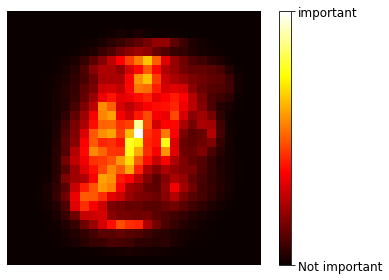

Figure 7-6


In [22]:
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks = [
                rnd_clf.feature_importances_.min(), 
                rnd_clf.feature_importances_.max()
])
cbar.ax.set_yticklabels(["Not important", "important"])

save_fig("Ensemble and RF - MNIST pixel importance with random forest")
plt.show()
print("Figure 7-6")

Random Forest are very useful to get a quick understancing of what features actually matter, espicially if you need to perform feature selection

# End Of Section: Random Forest

# Section: Boosting

**_Boosting_ (originally called _hypothesis boosting_) refers to any Ensemble method that can combine several weak learners into a strong learner.** 

The generaly idea of most boosting methods is to **train predictors sequentially, each traying to correct its predecessor**

##### AdaBoost

When training an **AdaBoost** classifier, the algorithm first trains a base classifier (e.g Decision Tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of missclassified training instances. This process continues to the next classifier and so on (see figure 7-7)

<img src="images/Ensemble and RF - AdaBoost sequential training.png">

As an example, lets train 5 classifiers on the moons dataset and show their decision boundaries

Saving figure Ensemble and RF - AdaBoost decision boundaries of predictors


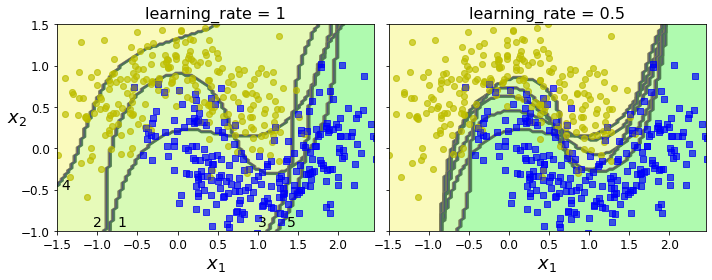

Figure 7-8


In [23]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")
    
save_fig("Ensemble and RF - AdaBoost decision boundaries of predictors")
plt.show()
print("Figure 7-8")

The first classifier gets many instances wrong, so their weights get boosted. The second classifier does a better job on these instances, and so on. 

The plot on the right illustrates the same sequence of predictors, except that the learning rate is halved (misclassified instances weights are boosted half as much in each iteration).

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set

> One drawback to this sequential learning is that it can't be parallelized, since each predictor relies on the previous predictor that has been trained and evaluated. Thus, it doesn't scale as well as bagging or pasting

**AdaBoost algorithm**. Each instance weight $w^{(i)}$ is initially set to $1/m$. A first predictor is trained and its weighted error rate $r_1$ is computed on the training set, equation 7-1

<img src="images/Ensemble and RF - AdaBoost algorithm, weighted error rate of the ith predictor.png">

The predictors weight $\alpha_j$ is then computed using equation 7-2, where $\eta$ is the learning rate hyperparameter (default to 1). **The more accurate the predictor is, the higher its weight will be.**

If its just guessing randomly, then its weight will be close to zero.

If its most often wrong, then its weight will be negative

<img src="images/Ensemble and RF - AdaBoost algorithm, predictor weight.png">

Next, the AdaBoost algorithm updates the instances weights, using equation 7-3 which boosts the weights of the misclassified instances

<img src="images/Ensemble and RF - AdaBoost algorithm, weight update rule.png">

Then all the instance weights are normalized (i.e, divideed by $\sum_{i = 1}^m w^{(i)}$)

Lastly, a new predictor is trained using the updated weights, and the whole process is repeated. The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.

To make predictions, AdaBoost simply computes the predictions of all the predictors and weights them using the predictor weights $\alpha_j$. The predicted class is the one that recieves the majority of weighted votes (see equation 7-4)

<img src="images/Ensemble and RF - AdaBoost algorithm, making predictions.png">

Scikit Learn uses a multiclass version of AdaBoost called **SAMME** (_Stagewise Additive Modeling using a Multiclass Exponential loss function_) when there are just two classes, which is the same as AdaBoost. If the predictors can estimate probabilities (_predict_proba()_ method), Scikit Learn can use a variant of **SAMME** called **SAMME.R** (the _R_ stands for "Real"), which relies on class probabilities rather than predictions and **generally performs better.**

Lets's train an AdaBoost classifier based on 200 _Decision stumps_ with Scikit Learn. A Decision stump is a Decision Tree with _max_depth=1_, that is, a tree composed with a single decision node plus two leaf nodes. This is the default base estimator for the AdaBoostClassifier

In [24]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                             n_estimators=200, learning_rate=0.5, 
                             algorithm="SAMME.R", random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

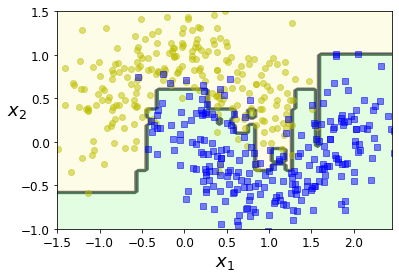

In [25]:
plot_decision_boundary(ada_clf, X, y)

> If AdaBoost is overfitting the training set, you can reduce the number of estimators or more strongly regularizing the base estimator

##### Gradient Boosting

**Gradient Boosting** works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instances weights at every iteration like **AdaBoost** does, **this method tries to fit the new predictor to the _residual errors_ made by the previous predictor.**

Let's go through a regression example using a Decision Trees as the base predictors. This is called _Gradient Tree Boosting_, or _Gradient Regression Trees_ (GBRT)

In [26]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [27]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=2)

Next, we'll train a second tree on the residual errors made by the first predictor

In [28]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then, we train a third tree on the residual made by the second predictor

In [29]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees

In [30]:
X_new = np.array([[0.8]])

In [31]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [32]:
y_pred

array([0.75026781])

Now let's plot the predictions of these three trees and the ensembles predictions

In [35]:
def plot_predictions(regressors, X, y, axes, style="r-", data_style="b.",
                     label=None, data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure Ensemble and RF - Gradient boosting, tree predictions and ensembles


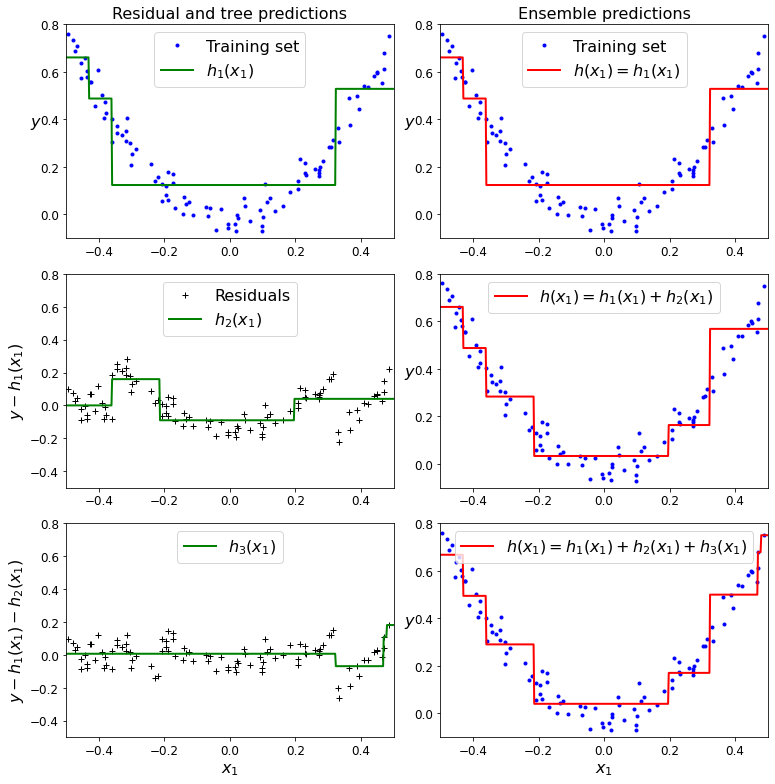

Figure 7-9


In [36]:
plt.figure(figsize=(11, 11))

#Top left plot
plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="g-",
                data_label="Training set", label="$h_1(x_1)$")
plt.ylabel("$y$", rotation=0, fontsize=16)
plt.title("Residual and tree predictions", fontsize=16)

#Top right plot
plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 data_label="Training set",
                 label="$h(x_1) = h_1(x_1)$")
plt.ylabel("$y$", rotation=0, fontsize=16)
plt.title("Ensemble predictions", fontsize=16)

#Middle left plot
plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.8], style="g-",
                data_style="k+", data_label="Residuals", label="$h_2(x_1)$")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

#Middle right plot
plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", rotation=0, fontsize=16)

#Bottom left plot
plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.8], style="g-",
                data_style="k+", label="$h_3(x_1)$")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

#Bottom right plot
plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.ylabel("$y$", rotation=0, fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

save_fig("Ensemble and RF - Gradient boosting, tree predictions and ensembles")
plt.show()
print("Figure 7-9")

**In the first row**, the ensemble has just one tree, so its predictions are the sames as the first tree's predictions.

**In the second row**, a new tree is trained on the residual errors of the first tree. On the right, you can see that the ensembles predictions are equal to the sum of the predictions of the first two trees.

**In the third row**, another tree is trained on the residual of the second tree. You can see that the ensemble's predictions gradually get better as trees are added to the ensemble.

A simpler way to train GBRT ensembles is to use Scikit Learn's ***GradientBoostingRegressor***. Like the RandomForestRegressor, it has hyperparameters to control the growth of Decision Trees (e.g, _max_depth_, _min_samples_leaf_), as well as hyperparameters to control the ensemble training, such as the number of trees (_n_estimators_)

In [37]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0,
                                random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

**The _learning_rate_ hyperparameter scales the contribution of each tree.** 

If it's set to a **low value**, such as 0.1, **more trees** in the ensemble are needed to fit the training set, but **predictions will usually generalize better.** This is a **regularization technique called _shrinkage_.**

Let's train two GBRT ensembles, one with a low learning rate: the one **to the left** doesn't have enough trees to fit the training set, while the one **tp the right** has too many trees and overfits the training set

In [38]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200,
                                     learning_rate=1.0, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=200,
                          random_state=42)

Saving figure Ensemble and RF - Gradient boosting, GBRT with not enough or too many predictors


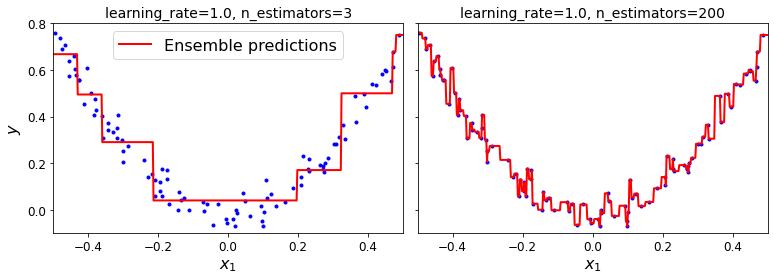

Figure 7-10


In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(11, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 label="Ensemble predictions")
plt.ylabel("$y$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate,
                                                    gbrt.n_estimators),
         fontsize=14)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.xlabel("$x_1$", fontsize=16)
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate,
                                                     gbrt_slow.n_estimators),
         fontsize=14)

save_fig("Ensemble and RF - Gradient boosting, GBRT with not enough or too many predictors")
plt.show()
print("Figure 7-10")

In order to find the optimal number of trees, we can use **early stopping.** We can use ***staged_predict()*** method to implement it; it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc)

Let's train a GBRT ensemble, then measure the validation error at each stage of training to find to optimal number of trees, and finally trian another GBRT ensemble using the optimal number of trees

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators,
                                     random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

Let's have a look at the validation errors (left plot), the the best model predictions (right plot)

In [41]:
min_error = np.min(errors)

Saving figure Ensemble and RF - Gradient boosting, GBRT early stopping


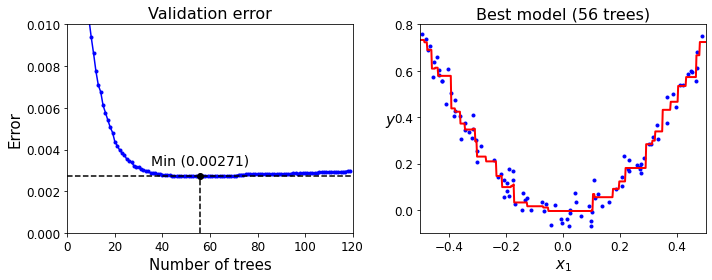

Figure 7-11


In [42]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Min ({:.5f})".format(min_error), ha="center", fontsize=14)
plt.xlabel("Number of trees", fontsize=15)
plt.ylabel("Error", fontsize=15)
plt.title("Validation error", fontsize=16)
plt.axis([0, 120, 0, 0.01])

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$y$", rotation=0, fontsize=15)
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=16)

save_fig("Ensemble and RF - Gradient boosting, GBRT early stopping")
plt.show()
print("Figure 7-11")

**Another way to implement early stopping is by actually stopping training early** (instead of training a large number of trees first and then looking back to find the optimal number). **Setting _warm_start=True_** which makes Scikit Learn keep existing trees when the _fit()_ method is called, allowing incremental training

Let's train a GBRT that stops training when the validation error doesn't improve for five iterations in a row

In [43]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf") #Value for comparison
error_go_up = 0

for n_estimators in range (1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_go_up = 0
    else: 
        error_go_up += 1
        if error_go_up == 5: #Stop after 5 iterations without any improvement
            break

In [44]:
print(gbrt.n_estimators)

61


In [45]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


GradientBoostingRegressor also supports a _subsample_ hyperparameter, which specifies the fraction of training instances to be used for training each tree. So, if _subsample=0.25_ then each tree is trained on 25% of the training instances, selected randomly. **This technique trades a higher bias for a lower variance.** It also speeds up training considerably. This is callded ***Stochastic Gradient Boosting.***